In [18]:
# ============================================================
# Inference & Evaluation Notebook — DownScaleXR
# ============================================================

import sys
from pathlib import Path
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)

In [19]:

# ============================================================
# Path setup
# ============================================================

PROJECT_ROOT = Path("..").resolve()
SRC_PATH = PROJECT_ROOT / "src"
sys.path.append(str(SRC_PATH))

from models import LeNetVariant

In [20]:

# ============================================================
# Model discovery
# ============================================================

MODELS_DIR = PROJECT_ROOT / "model"
CKPTS = list(MODELS_DIR.rglob("*.pt"))

assert CKPTS, "No model checkpoints found"

In [21]:

# ============================================================
# Dataset paths
# ============================================================

TEST_DIR = PROJECT_ROOT / "data" / "CXR" / "test"
IMG_SIZE = 320
CLASS_MAP = {"NORMAL": 0, "PNEUMONIA": 1}

In [22]:

# ============================================================
# Image loading
# ============================================================

def preprocess_image(path):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=(0, 1))  # [1, 1, H, W]
    return torch.from_numpy(img)

In [23]:

# ============================================================
# Load all test images
# ============================================================

def load_test_data():
    X, y = [], []

    for cls, label in CLASS_MAP.items():
        cls_dir = TEST_DIR / cls
        for img_path in cls_dir.glob("*"):
            if img_path.suffix.lower() not in {".jpg", ".png", ".jpeg"}:
                continue
            X.append(preprocess_image(img_path))
            y.append(label)

    X = torch.cat(X, dim=0)
    y = np.array(y)

    return X, y

X_test, y_test = load_test_data()
print(f"Loaded test set: {X_test.shape}")

Loaded test set: torch.Size([47, 1, 320, 320])


In [ ]:
# ============================================================
# Load model helper
# ============================================================

def load_model(ckpt_path):
    model_name = ckpt_path.parent.name
    cfg_path = PROJECT_ROOT / "configs" / f"model_{model_name}.yaml"

    model = LeNetVariant(cfg_path)
    model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
    model.eval()

    return model_name, model

In [ ]:
# ============================================================
# Inference + metrics
# ============================================================

def evaluate_model(model, X, y_true):
    with torch.no_grad():
        logits = model(X).squeeze()
        probs = torch.sigmoid(logits).numpy()

    y_pred = (probs >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, probs)
    }

    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

In [26]:

# ============================================================
# Run evaluation for all models
# ============================================================

results = {}

for ckpt in CKPTS:
    name, model = load_model(ckpt)
    metrics, cm = evaluate_model(model, X_test, y_test)
    results[name] = {"metrics": metrics, "cm": cm}

In [27]:

# ============================================================
# Print metrics table
# ============================================================

print("\n=== Test Set Performance ===")
for name, res in results.items():
    m = res["metrics"]
    print(
        f"{name:15s} | "
        f"AUC={m['auc']:.4f} | "
        f"F1={m['f1']:.4f} | "
        f"Acc={m['accuracy']:.4f}"
    )


=== Test Set Performance ===
lenet_avgpool   | AUC=0.9149 | F1=0.7755 | Acc=0.7660
lenet_maxpool   | AUC=0.9203 | F1=0.7797 | Acc=0.7234
lenet_strided   | AUC=0.9384 | F1=0.7797 | Acc=0.7234


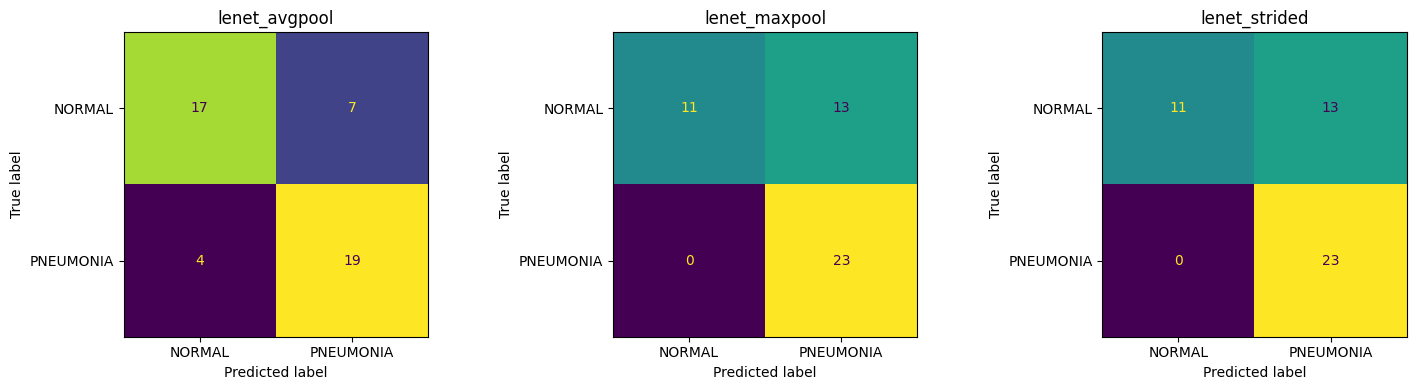

In [28]:
# ============================================================
# Plot confusion matrices
# ============================================================

fig, axes = plt.subplots(1, len(results), figsize=(5 * len(results), 4))

if len(results) == 1:
    axes = [axes]

for ax, (name, res) in zip(axes, results.items()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=res["cm"],
        display_labels=["NORMAL", "PNEUMONIA"]
    )
    disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()

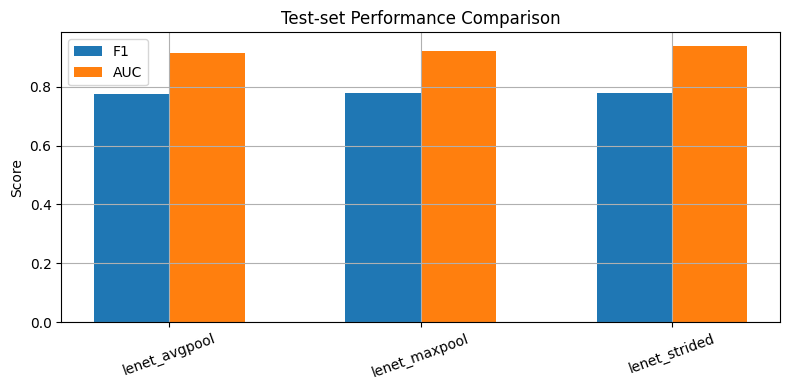

In [29]:
# ============================================================
# Bar plot comparison (F1 + AUC)
# ============================================================

names = list(results.keys())
f1s = [results[n]["metrics"]["f1"] for n in names]
aucs = [results[n]["metrics"]["auc"] for n in names]

x = np.arange(len(names))

plt.figure(figsize=(8, 4))
plt.bar(x - 0.15, f1s, width=0.3, label="F1")
plt.bar(x + 0.15, aucs, width=0.3, label="AUC")
plt.xticks(x, names, rotation=20)
plt.ylabel("Score")
plt.title("Test-set Performance Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ============================================================